# Import Library : 분석에 사용할 모듈 설치

"통계추론, 기계학습 및 딥러닝의 흐름에 시간패턴을 반영하려 진화"

"지도학습(예측 분류), 비지도학습 문제에 모두 활용되는 필수 알고리즘"

"미래 예측을 포함한 추천 서비스와 같은 비즈니스에 활용중"

<img src='./img/TS_Evolution.png'>

In [8]:
# !pip install --upgrade pip
# !python -m pip install --user --upgrade pip
# !pip install pandas-datareader
# !pip install tqdm
# !pip install xgboost
# !pip install lightgbm
# !pip install --user pmdarima

In [19]:
# Auto reload and user defined functions
%reload_ext autoreload
%autoreload 2
from module_regression import *
from module_classification import *
from module_timeseries import *

# Data manipulation and useful functions
import requests
from io import BytesIO
import random
from itertools import product
import scipy as sp

# Time series algorithms
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import AutoARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict

# **Base Algorithm:** Linear Regression

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


DateTime
2011-01-01 00:00:00    41.04
2011-01-01 01:00:00    41.04
2011-01-01 02:00:00    41.04
2011-01-01 03:00:00    41.04
2011-01-01 04:00:00    41.04
                       ...  
2012-06-30 19:00:00   233.88
2012-06-30 20:00:00   233.21
2012-06-30 21:00:00   232.25
2012-06-30 22:00:00   232.62
2012-06-30 23:00:00   236.96
Freq: H, Name: count_Day, Length: 13128, dtype: float64

Number_of_Total_X:  24
Number_of_Selected_X:  12


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.864
Model:                            OLS   Adj. R-squared (uncentered):              0.864
Method:                 Least Squares   F-statistic:                              6925.
Date:                Wed, 03 May 2023   Prob (F-statistic):                        0.00
Time:                        00:40:40   Log-Likelihood:                         -77008.
No. Observations:               13128   AIC:                                  1.540e+05
Df Residuals:                   13116   BIC:                                  1.541e+05
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
count_diff       1289.2806     25.881     49.816      0.000    1238.550    1340.011
holiday          7.141e+04   1.01e+04      7.044      0.000    5.15e+04    9.13e+04
count_seasonal   1270.9307     16.107     78.906      0.000    1239.359    1302.503
Day              1151.2606    168.230      6.843      0.000     821.505    1481.017
windspeed        -234.1084    180.733     -1.295      0.195    -588.370     120.154
Quarter_ver2     2.865e+04    930.475     30.787      0.000    2.68e+04    3.05e+04
Hour            -3514.0425    282.316    -12.447      0.000   -4067.422   -2960.663
weather         -2.423e+04   2238.550    -10.825      0.000   -2.86e+04   -1.98e+04
Quarter_Dummt_2  6.725e+04   3436.993     19.566      0.000    6.05e+04     7.4e+04
DayofWeek        1.621e+04    912.387     17.768      0.000    1.44e+04     1.8e+04
workingday       7.695e+04   4056.717     18.970      0.000     6.9e+04    8.49e+04
count_lag2       1061.0008     14.379     73.788      0.000    1032.816    1089.186
==============================================================================
Omnibus:                     1665.324   Durbin-Watson:                   0.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5853.426
Skew:                           0.626   Prob(JB):                         0.00
Kurtosis:                       6.022   Cond. No.                     1.53e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

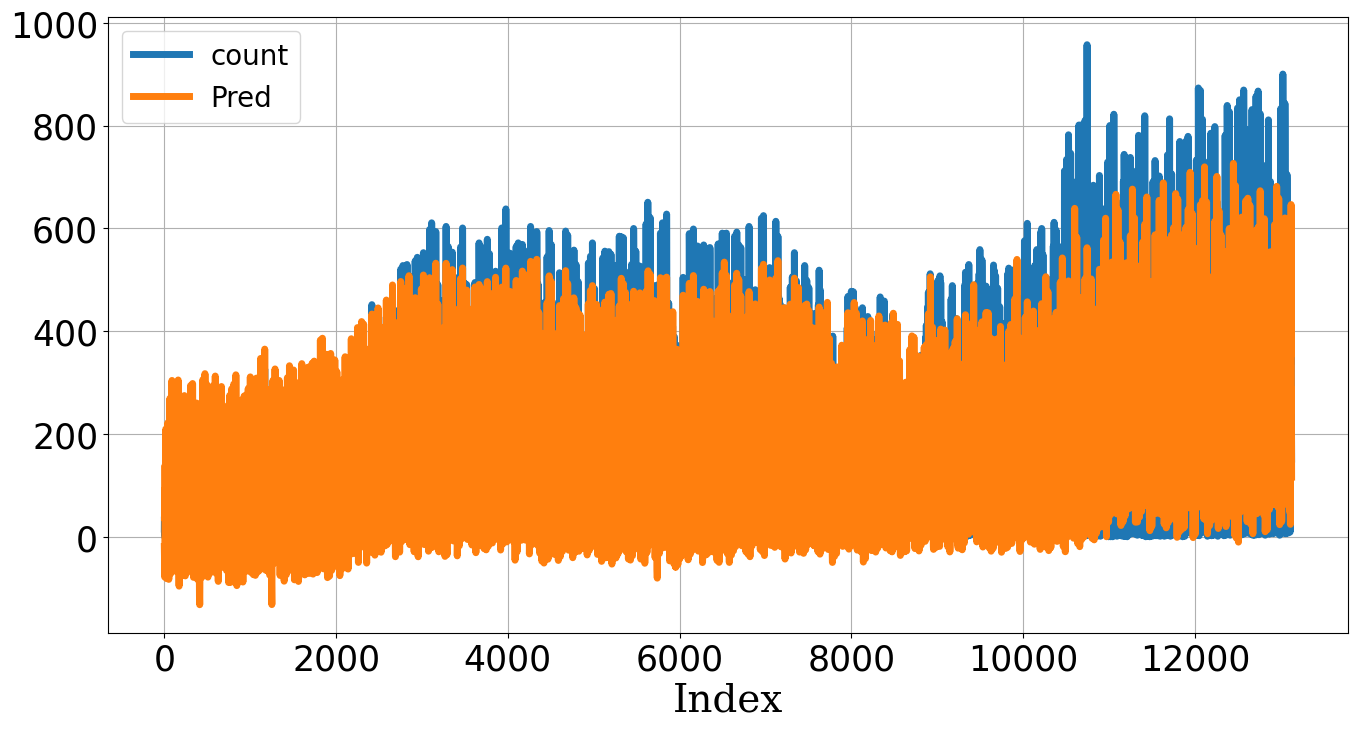

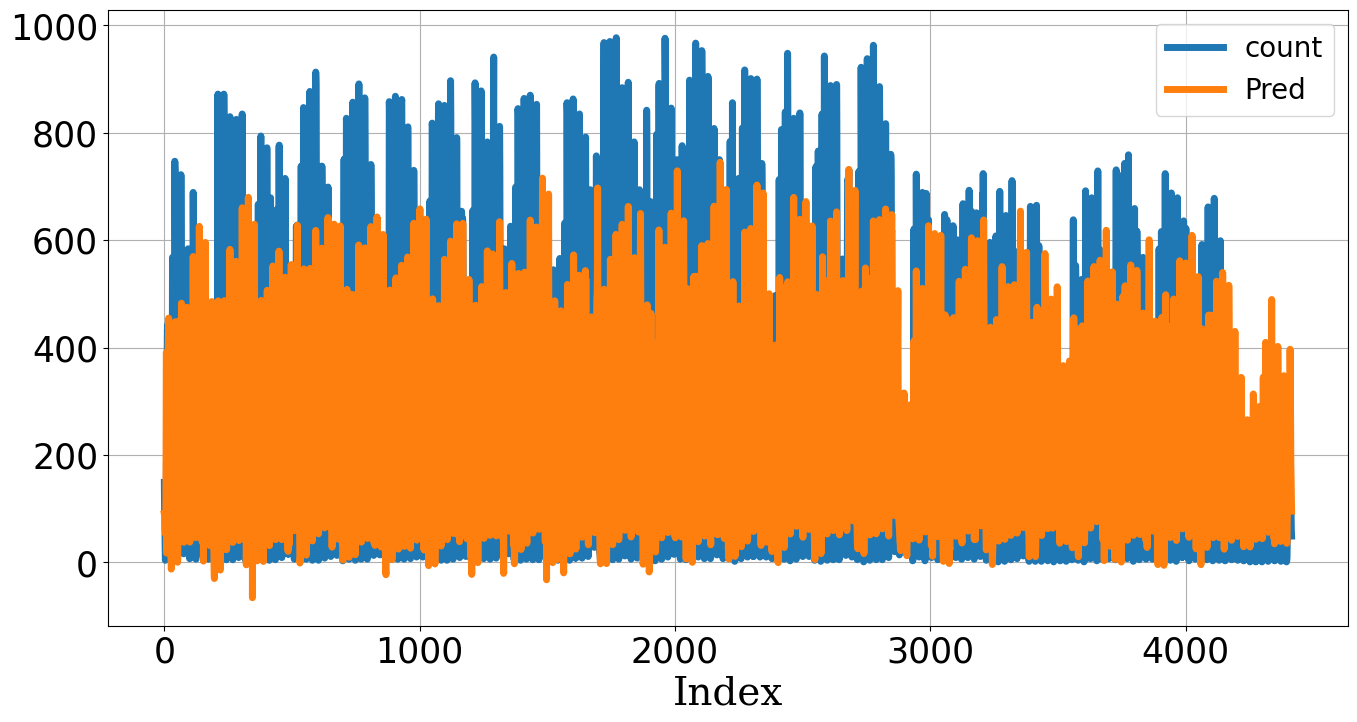

,MAE,MSE,MAPE
Train,60.84,"7,288.40",2.02
Test,99.87,"19,151.40",1.53


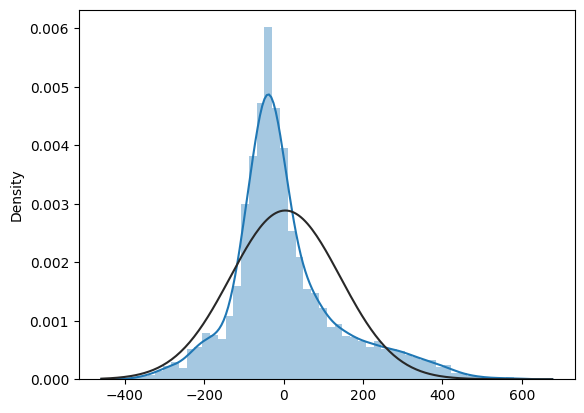

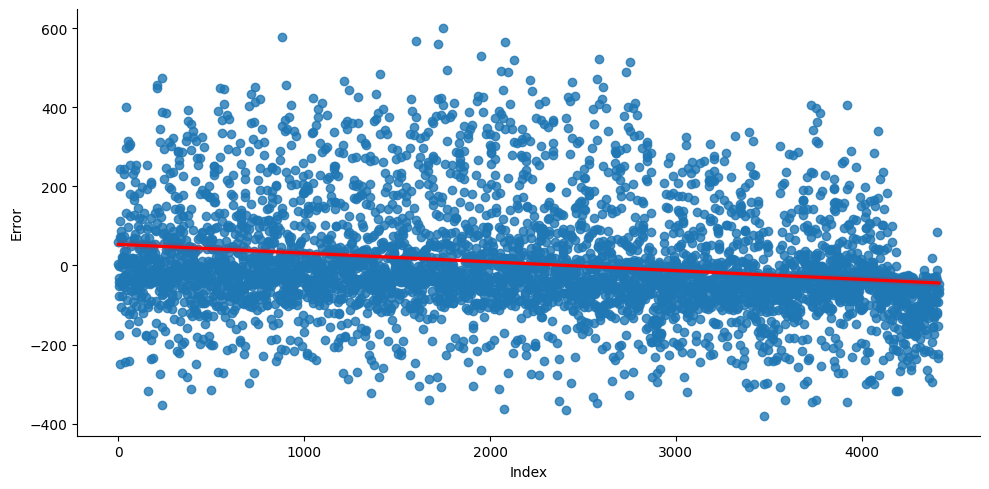

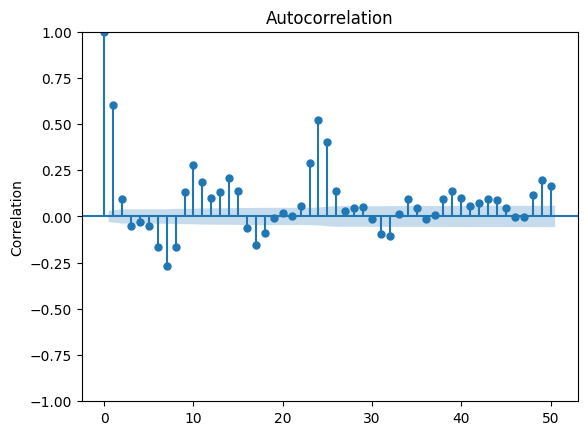

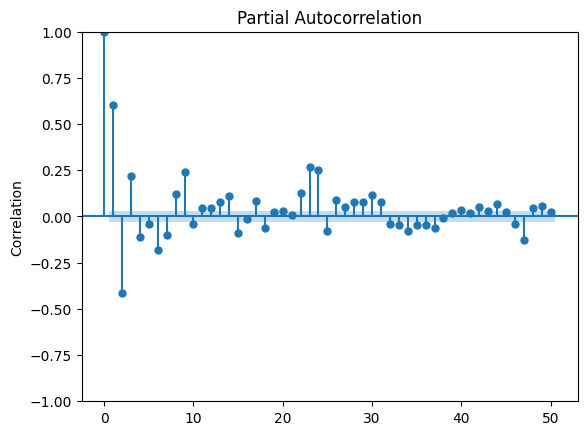

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.93,0.70,"2,631.01","6,552.71",-3.58,9.89
p-value,0.00,0.00,0.00,0.00,0.01,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,31.00,15.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [21]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
display(X_train['count_Day'])
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(), 
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# Linear Regression
model_lr = sm.OLS(Y_train, X_train_RSM).fit()
display(model_lr.summary())

Y_trpred = pd.DataFrame(model_lr.predict(X_train_RSM), columns=['Pred'])
Y_tepred = pd.DataFrame(model_lr.predict(X_test_RSM), columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score)

# 에러 분석
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)

# **Advanced Algorithm:** Random Forest

Train_size: (13128, 28) Test_size: (4416, 28)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)
Number_of_Total_X:  24
Number_of_Selected_X:  12


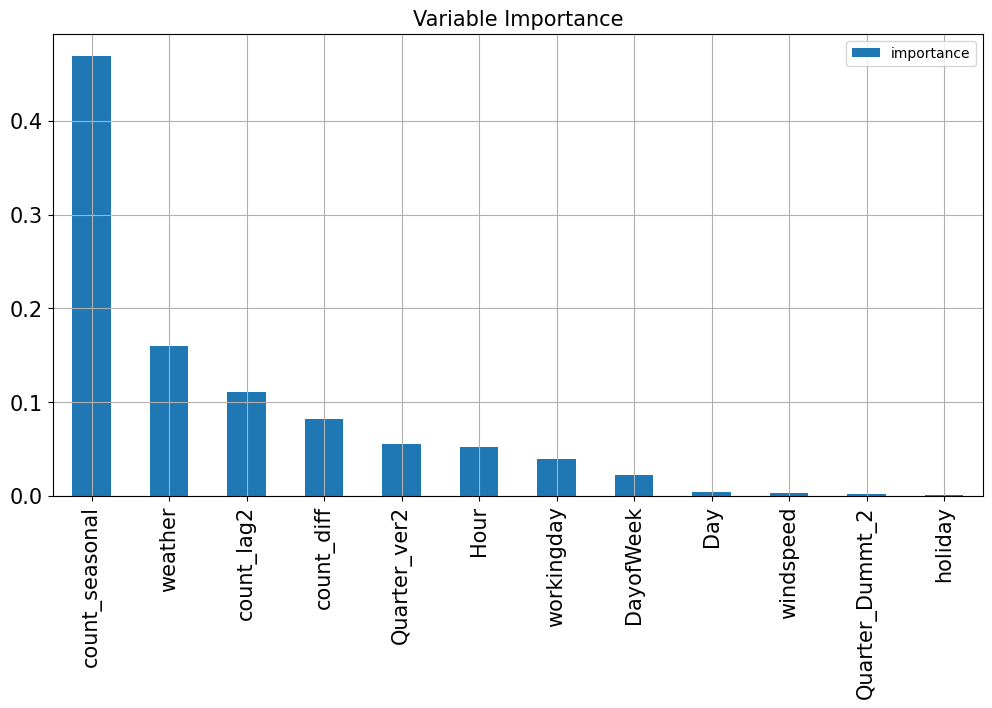

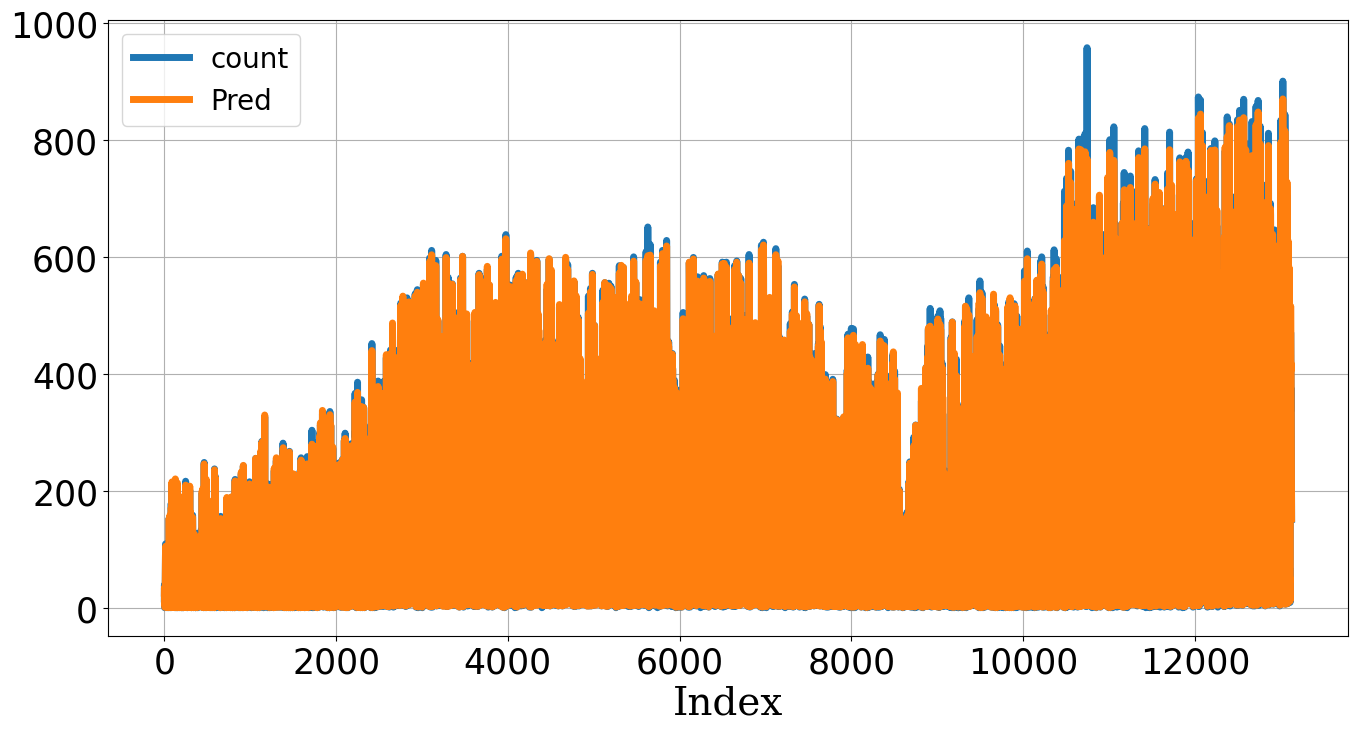

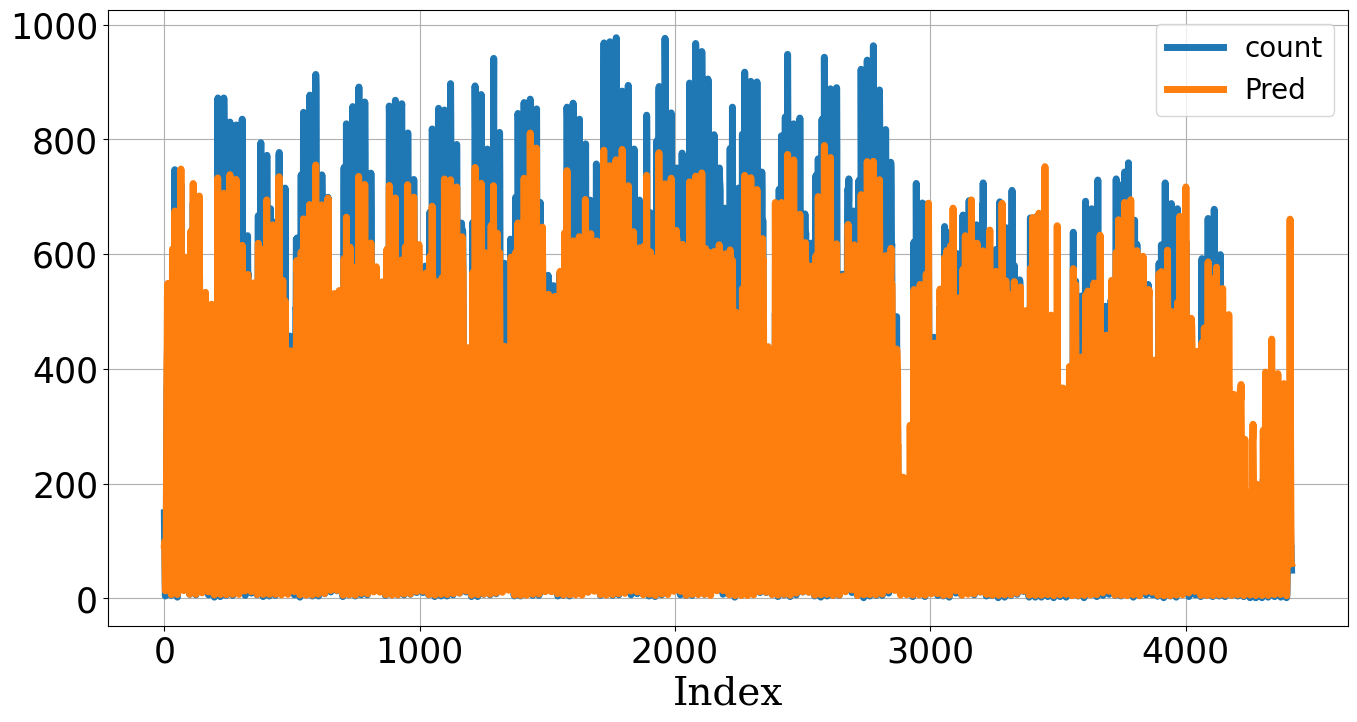

,MAE,MSE,MAPE
Train,6.54,123.38,0.09
Test,51.52,"6,749.92",0.40


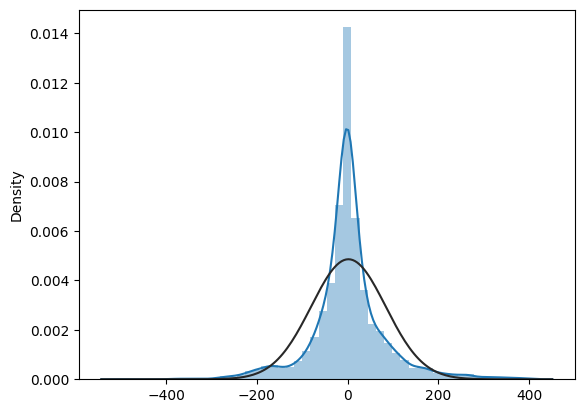

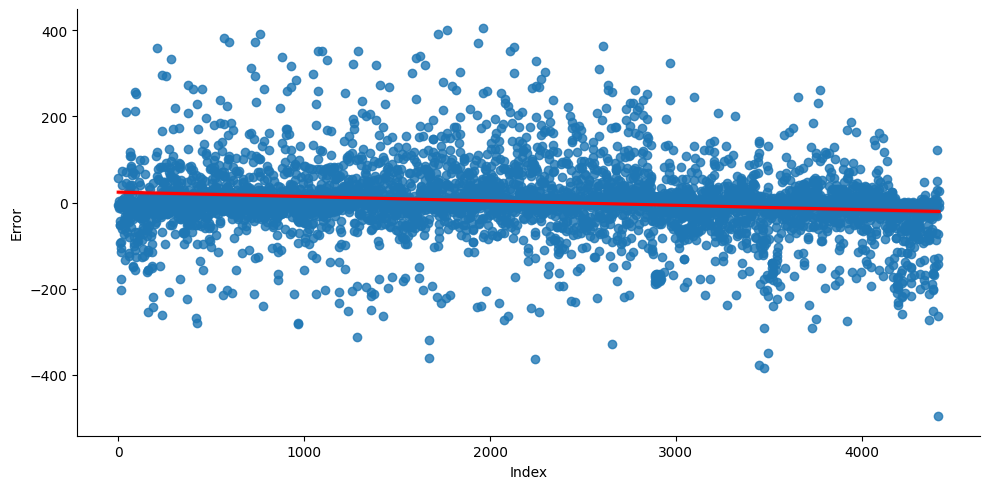

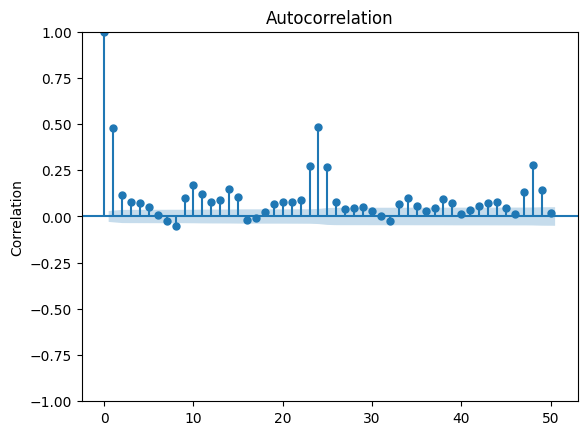

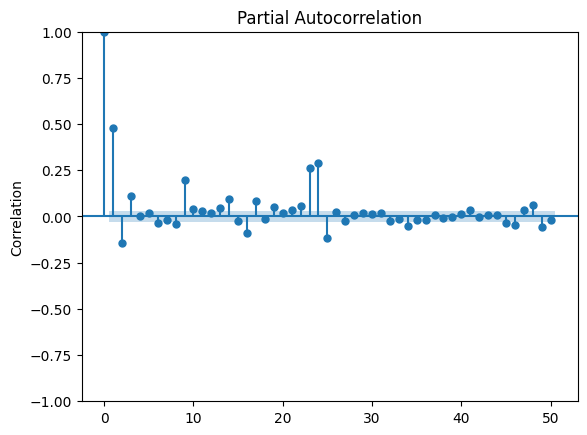

,Normality,Heteroscedasticity,Autocorr(lag10),Autocorr(lag50),Stationarity_ADF,Stationarity_KPSS
Test Statistics,0.90,0.86,"1,337.93","4,231.86",-5.83,4.49
p-value,0.00,0.00,0.00,0.00,0.00,0.01
Alternative,NaN,two-sided,NaN,NaN,NaN,NaN
Used Lag,NaN,NaN,NaN,NaN,26.00,21.00
Critical Value(1%),NaN,NaN,NaN,NaN,-3.43,0.74
Critical Value(5%),NaN,NaN,NaN,NaN,-2.86,0.46
Critical Value(10%),NaN,NaN,NaN,NaN,-2.57,0.35


In [23]:
# 데이터 로딩
location = os.path.join('.', 'data', 'Bike_Sharing_Demand_Full.csv')
df_all = pd.read_csv(location)

# 데이터 전처리
df_fe = feature_engineering(df_all)

# 데이터 분리
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in df_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, '2012-07-01')

# 데이터 전처리(현실성)
### Reality ###
target = ['count_trend', 'count_seasonal', 'count_Day', 'count_Week', 'count_diff']
X_train_R, X_test_R = feature_engineering_year_duplicated(X_train, X_test, target)
target = ['count_lag1', 'count_lag2']
X_test_R = feature_engineering_lag_modified(Y_test, X_test_R, target)
###############
### Scaling ###
X_train_RS, X_test_RS = feature_engineering_scaling(preprocessing.Normalizer(),
                                                    X_train_R, X_test_R)
###############
### Multicollinearity ###
print('Number_of_Total_X: ', len(X_train_RS.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train_RS, 12)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train_RS[X_colname_vif].copy(), X_test_RS[X_colname_vif].copy()
#########################

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor(n_estimators=100, 
                                 random_state=123,
                                 n_jobs=-1)
model_rf.fit(X_train_RSM, Y_train)
# 변수 중요도
Variable_Importance = pd.DataFrame([model_rf.feature_importances_],
                                   columns=X_train_RSM.columns,
                                   index=['importance']).T.sort_values(by=['importance'], ascending=False)
Variable_Importance.plot.bar(figsize=(12,6), fontsize=15)
plt.title('Variable Importance', fontsize=15)
plt.grid()
plt.show()

Y_trpred = pd.DataFrame(model_rf.predict(X_train_RSM),
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model_rf.predict(X_test_RSM),
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score)

# 에러 분석
Resid_te = Y_test - Y_tepred.values
Resid_te.columns = ['Error']
Error_te = error_analysis_timeseries(X_test, Y_tepred, Resid_te, graph_on=True)
display(Error_te)